In [2]:
!pip install torch==2.0.0
!pip install skorch
!pip install numpy
!pip install sklearn
!pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\HLoh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\HLoh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\HLoh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\HLoh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\HLoh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import torch #torch==2.0.0
import skorch #skorch==0.12.1
import numpy as np #numpy==1.21.1
import sklearn #sklearn==0.0.post1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor
from torch import nn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [4]:
SEED = 42

In [5]:
#Import french motor dataset
df = pd.read_csv('./data/freMTPL2freq.csv')

In [6]:
#transformations and corrections
df['VehPower'] = df['VehPower'].astype(object) # categorical ordinal
df['ClaimNb'] = pd.to_numeric(df['ClaimNb'])
df['ClaimNb'].values[df['ClaimNb']>4] = 4 # corrected for unreasonable observations (see M.V. Wuthrich)
df['VehAge'].values[df['VehAge']>20] = 20 # capped for NN training (see M.V. Wuthrich)
df['DrivAge'].values[df['DrivAge']>90] = 90 # capped for NN training (see M.V. Wuthrich)
df['BonusMalus'].values[df['BonusMalus']>150] = 150 # capped for NN training (see M.V. Wuthrich)
df['Density']=np.log(df['Density']) # logged for NN training     (see M.V. Wuthrich)
df['Exposure'].values[df['Exposure']>1] = 1 # corrected for unreasonable observations (see M.V. Wuthrich)
df_new = df.drop(['IDpol'], axis=1) # variable not used

#Encode the data as per Wuthrich
df_new_encoded = pd.get_dummies(df_new, columns=['VehBrand', 'Region'], drop_first=True)

cleanup_nums = {"Area":     {"A": 1, "B": 2, "C": 3, "D": 4, "E":5, "F": 6}, "VehGas":   {"Regular": 1, "Diesel": 2} }

#Apply label encoding - NOT ONE-HOT/DUMMY
df_new_encoded = df_new_encoded.replace(cleanup_nums)

##
## Do we want to do EDA after or before MinMaxScaler is applied?
##

df_new_encoded = df_new_encoded.dropna()

###Apply MinMaxScaler as per Wuthrich
scaler = MinMaxScaler()
df_new_encoded[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] = scaler.fit_transform(df_new_encoded[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']])


In [7]:
df_new_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
ClaimNb,678013.0,0.053179,0.237954,0.000000,0.000000,0.000000,0.000000,4.0
Exposure,678013.0,0.528545,0.364081,0.002732,0.180000,0.490000,0.990000,1.0
Area,678013.0,0.457940,0.276537,0.000000,0.200000,0.400000,0.600000,1.0
VehPower,678013.0,0.223148,0.186446,0.000000,0.090909,0.181818,0.272727,1.0
VehAge,678013.0,0.348806,0.269948,0.000000,0.100000,0.300000,0.550000,1.0
DrivAge,678013.0,0.381901,0.196248,0.000000,0.222222,0.361111,0.513889,1.0
BonusMalus,678013.0,0.097572,0.156079,0.000000,0.000000,0.000000,0.140000,1.0
VehGas,678013.0,1.489867,0.499898,1.000000,1.000000,1.000000,2.000000,2.0
Density,678013.0,0.586242,0.183313,0.000000,0.443157,0.585461,0.726545,1.0
VehBrand_B10,678013.0,0.026116,0.159480,0.000000,0.000000,0.000000,0.000000,1.0


In [8]:
df_new_encoded

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand_B10,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1,0.10000,0.6,0.090909,0.0,0.513889,0.00,1,0.696240,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.77000,0.6,0.090909,0.0,0.513889,0.00,1,0.696240,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0.75000,0.2,0.181818,0.1,0.472222,0.00,2,0.390939,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.09000,0.2,0.272727,0.0,0.388889,0.00,2,0.424432,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0.84000,0.2,0.272727,0.0,0.388889,0.00,2,0.424432,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,0.8,0.000000,0.0,0.500000,0.00,1,0.794506,0,...,0,0,0,0,0,0,0,0,1,0
678009,0,0.00274,0.8,0.000000,0.0,0.319444,0.45,1,0.901175,0,...,0,0,0,0,0,0,0,0,0,0
678010,0,0.00274,0.6,0.181818,0.1,0.375000,0.00,2,0.704424,0,...,0,0,0,0,0,1,0,0,0,0
678011,0,0.00274,0.2,0.000000,0.0,0.583333,0.00,1,0.446301,0,...,0,0,0,0,0,0,0,0,0,0


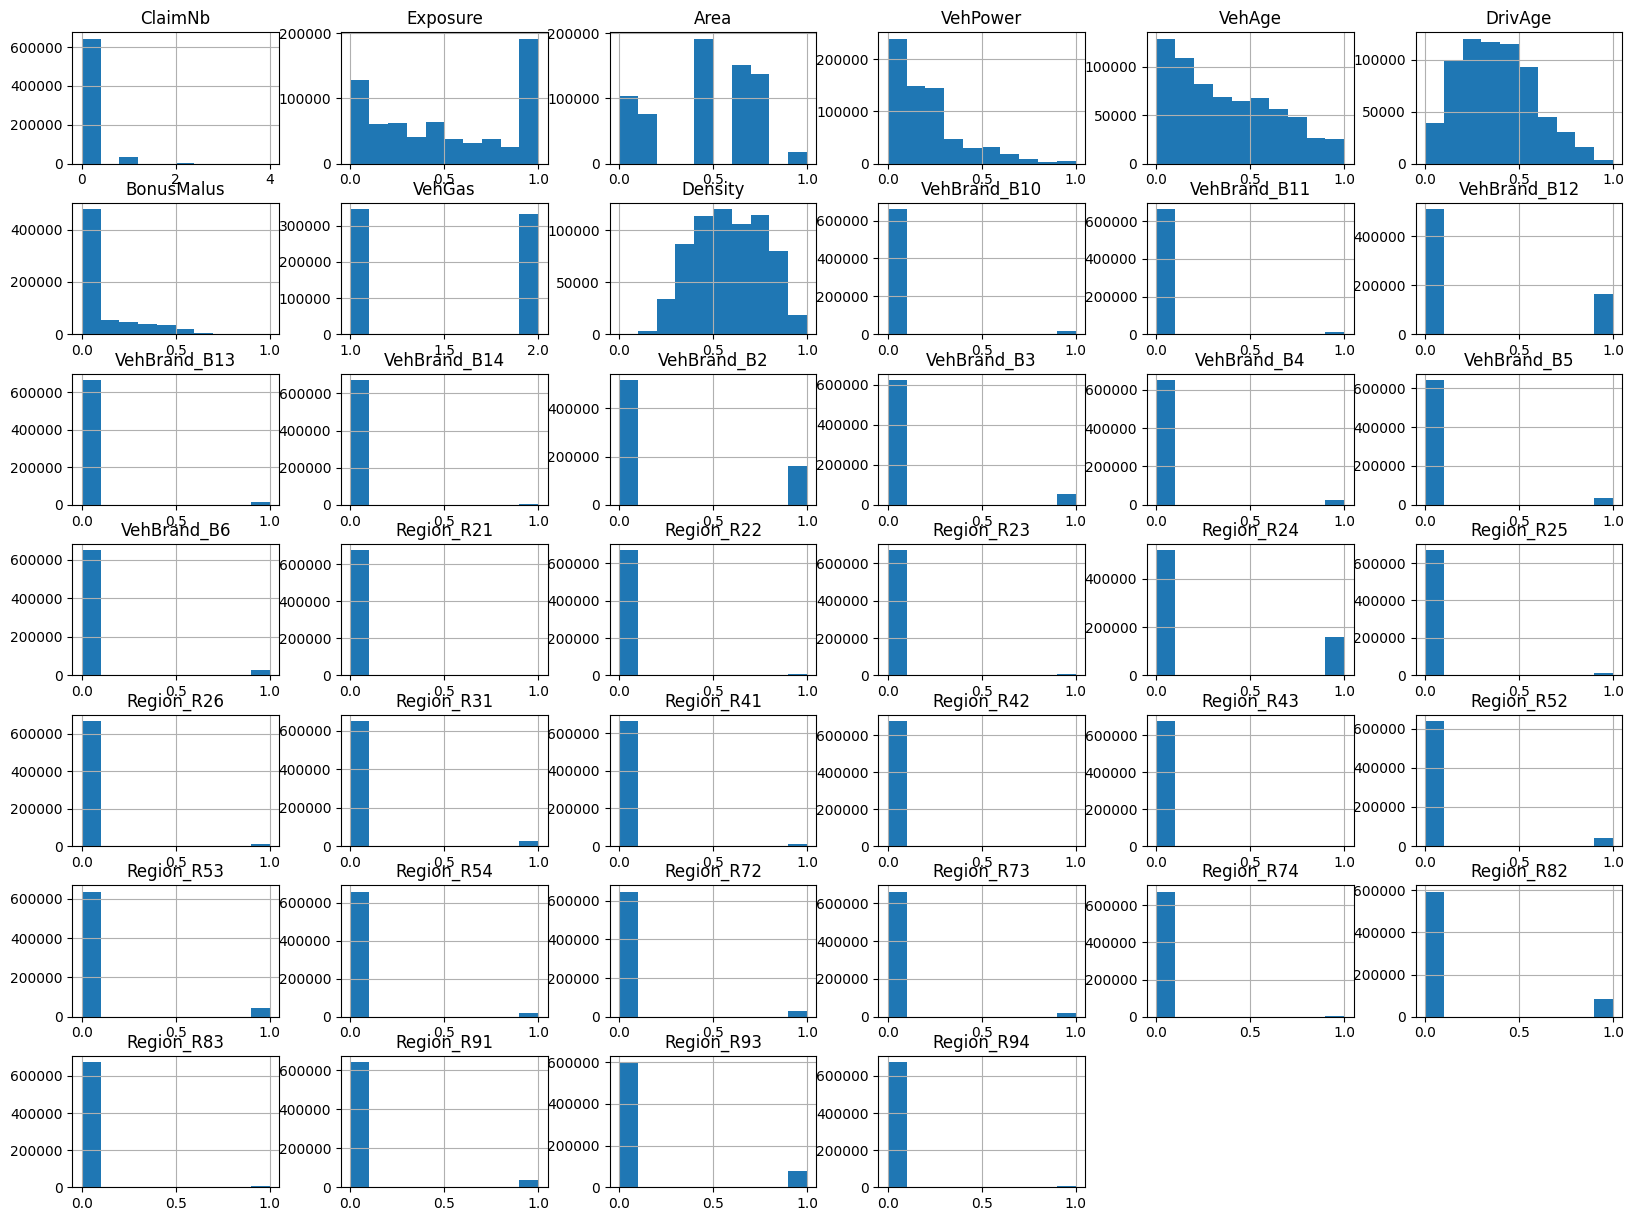

In [9]:
df_new_encoded.hist(figsize=(20, 15))
plt.show()

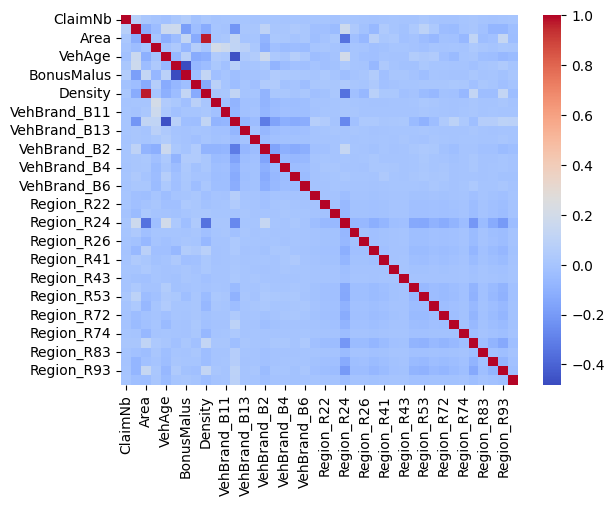

In [10]:
sns.heatmap(df_new_encoded.corr(), annot=False, cmap='coolwarm')
plt.show()

StopIteration: 

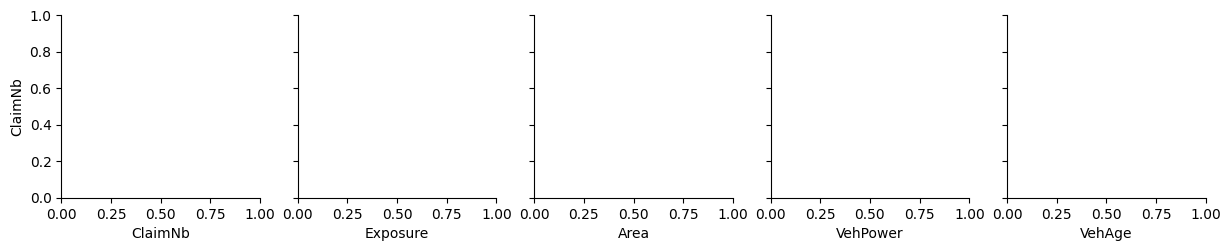

In [11]:
for i in range(0, len(df_new_encoded.columns), 5):
    sns.pairplot(data = df_new_encoded,
                x_vars = df_new_encoded.columns[i:i+5],
                y_vars = ['ClaimNb'])

<AxesSubplot: xlabel='Exposure'>

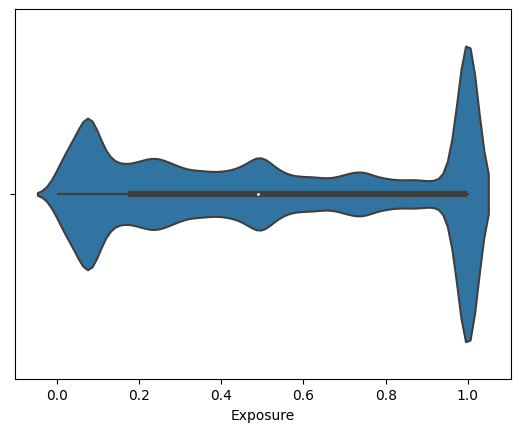

In [12]:
## Full Dataset
sns.violinplot(x=df_new_encoded["Exposure"])

<AxesSubplot: xlabel='Area', ylabel='Exposure'>

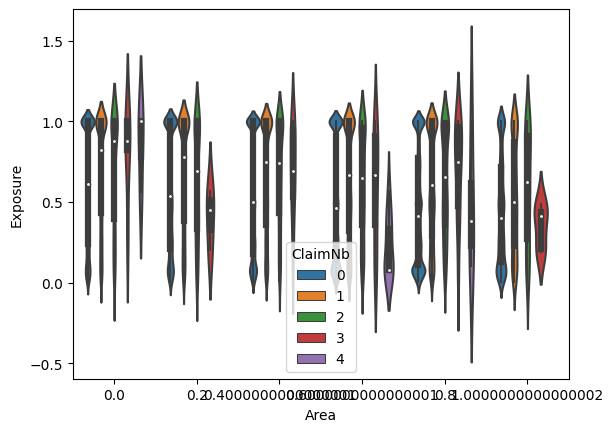

In [13]:
sns.violinplot(data=df_new_encoded, y="Exposure", x="Area", hue="ClaimNb")

<AxesSubplot: xlabel='ClaimNb', ylabel='Exposure'>

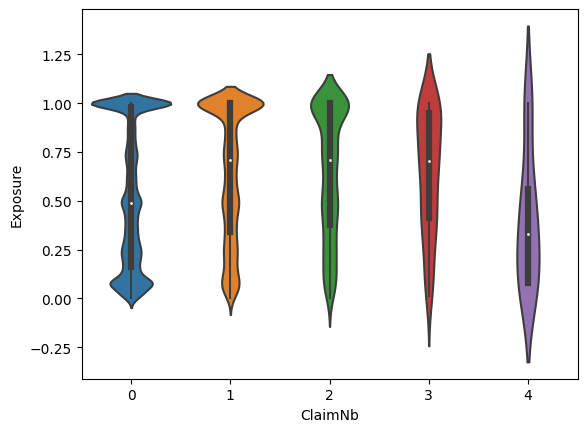

In [14]:
sns.violinplot(data=df_new_encoded, y="Exposure", x="ClaimNb")

In [15]:
###################################################################
### BELOW SECTION IS FOR EDA SECTION IN THE REPORT ################
###################################################################

In [16]:
#Import french motor dataset 10 agents

df_X_train_0 = pd.read_csv('./data/X_train_0.csv')
df_X_train_1 = pd.read_csv('./data/X_train_1.csv')
df_X_train_2 = pd.read_csv('./data/X_train_2.csv')
df_X_train_3 = pd.read_csv('./data/X_train_3.csv')
df_X_train_4 = pd.read_csv('./data/X_train_4.csv')
df_X_train_5 = pd.read_csv('./data/X_train_5.csv')
df_X_train_6 = pd.read_csv('./data/X_train_6.csv')
df_X_train_7 = pd.read_csv('./data/X_train_7.csv')
df_X_train_8 = pd.read_csv('./data/X_train_8.csv')
df_X_train_9 = pd.read_csv('./data/X_train_9.csv')

df_y_tr_0 = pd.read_csv('./data/y_tr_0.csv')
df_y_tr_1 = pd.read_csv('./data/y_tr_1.csv')
df_y_tr_2 = pd.read_csv('./data/y_tr_2.csv')
df_y_tr_3 = pd.read_csv('./data/y_tr_3.csv')
df_y_tr_4 = pd.read_csv('./data/y_tr_4.csv')
df_y_tr_5 = pd.read_csv('./data/y_tr_5.csv')
df_y_tr_6 = pd.read_csv('./data/y_tr_6.csv')
df_y_tr_7 = pd.read_csv('./data/y_tr_7.csv')
df_y_tr_8 = pd.read_csv('./data/y_tr_8.csv')
df_y_tr_9 = pd.read_csv('./data/y_tr_9.csv')

df_X_val_0 = pd.read_csv('./data/X_val_0.csv')
df_X_val_1 = pd.read_csv('./data/X_val_1.csv')
df_X_val_2 = pd.read_csv('./data/X_val_2.csv')
df_X_val_3 = pd.read_csv('./data/X_val_3.csv')
df_X_val_4 = pd.read_csv('./data/X_val_4.csv')
df_X_val_5 = pd.read_csv('./data/X_val_5.csv')
df_X_val_6 = pd.read_csv('./data/X_val_6.csv')
df_X_val_7 = pd.read_csv('./data/X_val_7.csv')
df_X_val_8 = pd.read_csv('./data/X_val_8.csv')
df_X_val_9 = pd.read_csv('./data/X_val_9.csv')

df_y_vl_0 = pd.read_csv('./data/y_vl_0.csv')
df_y_vl_1 = pd.read_csv('./data/y_vl_1.csv')
df_y_vl_2 = pd.read_csv('./data/y_vl_2.csv')
df_y_vl_3 = pd.read_csv('./data/y_vl_3.csv')
df_y_vl_4 = pd.read_csv('./data/y_vl_4.csv')
df_y_vl_5 = pd.read_csv('./data/y_vl_5.csv')
df_y_vl_6 = pd.read_csv('./data/y_vl_6.csv')
df_y_vl_7 = pd.read_csv('./data/y_vl_7.csv')
df_y_vl_8 = pd.read_csv('./data/y_vl_8.csv')
df_y_vl_9 = pd.read_csv('./data/y_vl_9.csv')

df_X_test = pd.read_csv('./data/X_test.csv')
df_y_test = pd.read_csv('./data/y_test.csv')
#df_X_val = pd.read_csv('./data/X_val.csv')
#df_y_vl = pd.read_csv('./data/y_vl.csv')

#no_obj_cols = [var for var in df_X_train_0.columns if df_X_train_0[var].dtype!='object']
#print(df_X_train_0[no_obj_cols].describe().T)

In [17]:
## Merging Datasets

In [18]:
df_Xy_tr_0 = pd.concat([df_y_tr_0, df_X_train_0], ignore_index=True, sort=False)
df_Xy_tr_1 = pd.concat([df_y_tr_1, df_X_train_1], ignore_index=True, sort=False)
df_Xy_tr_2 = pd.concat([df_y_tr_2, df_X_train_2], ignore_index=True, sort=False)
df_Xy_tr_3 = pd.concat([df_y_tr_3, df_X_train_3], ignore_index=True, sort=False)
df_Xy_tr_4 = pd.concat([df_y_tr_4, df_X_train_4], ignore_index=True, sort=False)
df_Xy_tr_5 = pd.concat([df_y_tr_5, df_X_train_5], ignore_index=True, sort=False)
df_Xy_tr_6 = pd.concat([df_y_tr_6, df_X_train_6], ignore_index=True, sort=False)
df_Xy_tr_7 = pd.concat([df_y_tr_7, df_X_train_7], ignore_index=True, sort=False)
df_Xy_tr_8 = pd.concat([df_y_tr_8, df_X_train_8], ignore_index=True, sort=False)
df_Xy_tr_9 = pd.concat([df_y_tr_9, df_X_train_9], ignore_index=True, sort=False)

In [19]:
df_Xy_val_0 = pd.concat([df_y_vl_0, df_X_val_0], ignore_index=True, sort=False)
df_Xy_val_1 = pd.concat([df_y_vl_1, df_X_val_1], ignore_index=True, sort=False)
df_Xy_val_2 = pd.concat([df_y_vl_2, df_X_val_2], ignore_index=True, sort=False)
df_Xy_val_3 = pd.concat([df_y_vl_3, df_X_val_3], ignore_index=True, sort=False)
df_Xy_val_4 = pd.concat([df_y_vl_4, df_X_val_4], ignore_index=True, sort=False)
df_Xy_val_5 = pd.concat([df_y_vl_5, df_X_val_5], ignore_index=True, sort=False)
df_Xy_val_6 = pd.concat([df_y_vl_6, df_X_val_6], ignore_index=True, sort=False)
df_Xy_val_7 = pd.concat([df_y_vl_7, df_X_val_7], ignore_index=True, sort=False)
df_Xy_val_8 = pd.concat([df_y_vl_8, df_X_val_8], ignore_index=True, sort=False)
df_Xy_val_9 = pd.concat([df_y_vl_9, df_X_val_9], ignore_index=True, sort=False)

In [20]:
## Test Dataset
df_Xy_test = pd.concat([df_y_test, df_X_test], ignore_index=True, sort=False)

In [21]:
df_Xy_test.rename(columns = {'0':'ClaimNb'}, inplace =True)

In [22]:
df_Xy_tr_0 = pd.concat([df_y_tr_0, df_X_train_0], ignore_index=True, sort=False)

In [23]:
## Merging Datasets - Train/Val

In [24]:
## Merging Datasets - Train/Val
df_Xy_trvl_0 = pd.concat([df_Xy_tr_0, df_Xy_val_0], ignore_index=True, sort=False)
df_Xy_trvl_1 = pd.concat([df_Xy_tr_1, df_Xy_val_1], ignore_index=True, sort=False)
df_Xy_trvl_2 = pd.concat([df_Xy_tr_2, df_Xy_val_2], ignore_index=True, sort=False)
df_Xy_trvl_3 = pd.concat([df_Xy_tr_3, df_Xy_val_3], ignore_index=True, sort=False)
df_Xy_trvl_4 = pd.concat([df_Xy_tr_4, df_Xy_val_4], ignore_index=True, sort=False)
df_Xy_trvl_5 = pd.concat([df_Xy_tr_5, df_Xy_val_5], ignore_index=True, sort=False)
df_Xy_trvl_6 = pd.concat([df_Xy_tr_6, df_Xy_val_6], ignore_index=True, sort=False)
df_Xy_trvl_7 = pd.concat([df_Xy_tr_7, df_Xy_val_7], ignore_index=True, sort=False)
df_Xy_trvl_8 = pd.concat([df_Xy_tr_8, df_Xy_val_8], ignore_index=True, sort=False)
df_Xy_trvl_9 = pd.concat([df_Xy_tr_9, df_Xy_val_9], ignore_index=True, sort=False)

In [25]:
## Rename Column to y=ClaimNb
df_Xy_trvl_0.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_1.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_2.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_3.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_4.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_5.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_6.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_7.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_8.rename(columns = {'0':'ClaimNb'}, inplace =True)
df_Xy_trvl_9.rename(columns = {'0':'ClaimNb'}, inplace =True)

In [26]:
## Adding Column of Data for Agents
df_Xy_trvl_0_0 = df_Xy_trvl_0.assign(agent = 0)
df_Xy_trvl_0_1 = df_Xy_trvl_1.assign(agent = 1)
df_Xy_trvl_0_2 = df_Xy_trvl_2.assign(agent = 2)
df_Xy_trvl_0_3 = df_Xy_trvl_3.assign(agent = 3)
df_Xy_trvl_0_4 = df_Xy_trvl_4.assign(agent = 4)
df_Xy_trvl_0_5 = df_Xy_trvl_5.assign(agent = 5)
df_Xy_trvl_0_6 = df_Xy_trvl_6.assign(agent = 6)
df_Xy_trvl_0_7 = df_Xy_trvl_7.assign(agent = 7)
df_Xy_trvl_0_8 = df_Xy_trvl_8.assign(agent = 8)
df_Xy_trvl_0_9 = df_Xy_trvl_9.assign(agent = 9)


In [27]:
df_new_encoded_99 = df_new_encoded.assign(agent = 'Full')

In [28]:
df_Xy_test = df_Xy_test.assign(agent = 'Test')

In [43]:
## Re-concat all 10 agents
##df_Xy_full = pd.concat([df_Xy_trvl_0_0, df_Xy_trvl_0_1, df_Xy_trvl_0_2, df_Xy_trvl_0_3, df_Xy_trvl_0_4, df_Xy_trvl_0_5, df_Xy_trvl_0_6, df_Xy_trvl_0_7, df_Xy_trvl_0_8, df_Xy_trvl_0_9, df_Xy_test, df_new_encoded_99], ignore_index=True, sort=False)

##
##
##
## Re-concat all 10 agents EXCLUDING FULL AND TEST
df_Xy_full = pd.concat([df_Xy_trvl_0_0, df_Xy_trvl_0_1, df_Xy_trvl_0_2, df_Xy_trvl_0_3, df_Xy_trvl_0_4, df_Xy_trvl_0_5, df_Xy_trvl_0_6, df_Xy_trvl_0_7, df_Xy_trvl_0_8, df_Xy_trvl_0_9], ignore_index=True, sort=False)

In [45]:
df_Xy_full.describe().T

,count,mean,std,min,25%,50%,75%,max
ClaimNb,542410.0,0.053268,0.237968,0.000000,0.000000,0.000000,0.000000,4.0
Exposure,542410.0,0.528734,0.363979,0.002732,0.180000,0.490000,0.990000,1.0
Area,542410.0,0.457995,0.276643,0.000000,0.200000,0.400000,0.600000,1.0
VehPower,542410.0,0.223162,0.186399,0.000000,0.090909,0.181818,0.272727,1.0
VehAge,542410.0,0.349182,0.270135,0.000000,0.100000,0.300000,0.550000,1.0
DrivAge,542410.0,0.381859,0.196201,0.000000,0.222222,0.361111,0.513889,1.0
BonusMalus,542410.0,0.097726,0.156126,0.000000,0.000000,0.000000,0.140000,1.0
VehGas,542410.0,1.489808,0.499897,1.000000,1.000000,1.000000,2.000000,2.0
Density,542410.0,0.586322,0.183332,0.000000,0.443157,0.585461,0.726545,1.0
VehBrand_B10,542410.0,0.026191,0.159702,0.000000,0.000000,0.000000,0.000000,1.0


<AxesSubplot: xlabel='agent', ylabel='ClaimNb'>

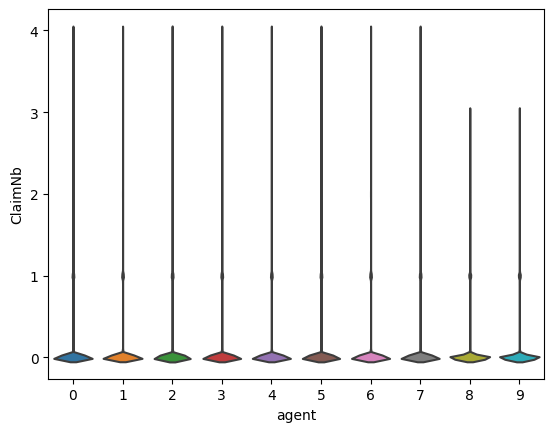

In [46]:
sns.violinplot(data=df_Xy_full, x="agent", y="ClaimNb", inner=None)

<AxesSubplot: xlabel='agent', ylabel='ClaimNb'>

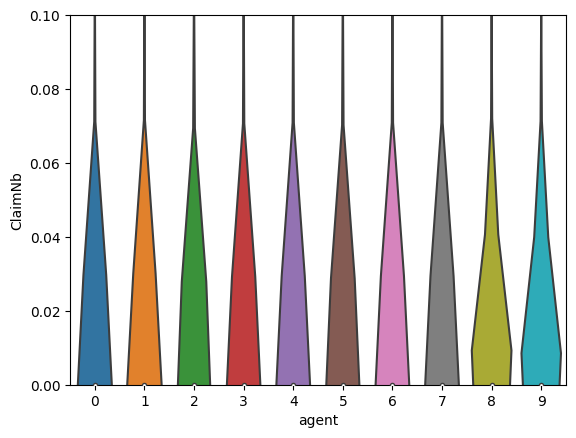

In [47]:
import matplotlib.pyplot as plt
##ClaimNB Truncated at 0.1 for better view.
plt.ylim(0, 0.1)
sns.violinplot(data=df_Xy_full, x="agent", y="ClaimNb")

<AxesSubplot: xlabel='agent', ylabel='Exposure'>

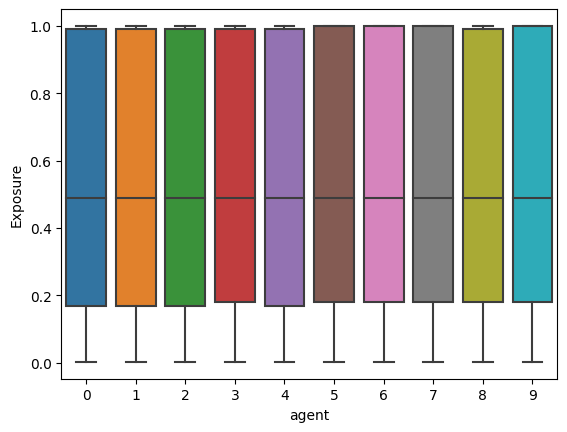

In [48]:
sns.boxplot(data=df_Xy_full, x="agent", y="Exposure")

<AxesSubplot: xlabel='agent', ylabel='Exposure'>

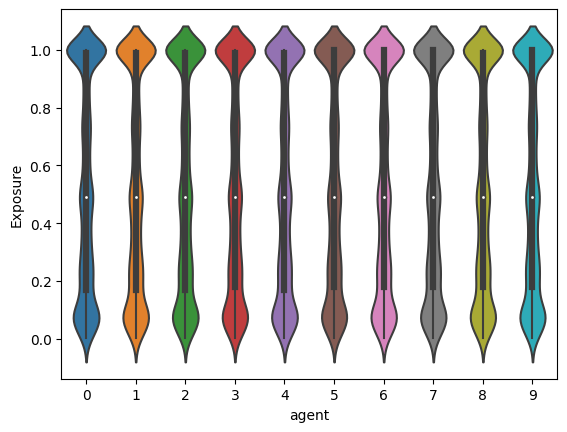

In [49]:
sns.violinplot(data=df_Xy_full, x="agent", y="Exposure")

<AxesSubplot: xlabel='agent', ylabel='ClaimNb'>

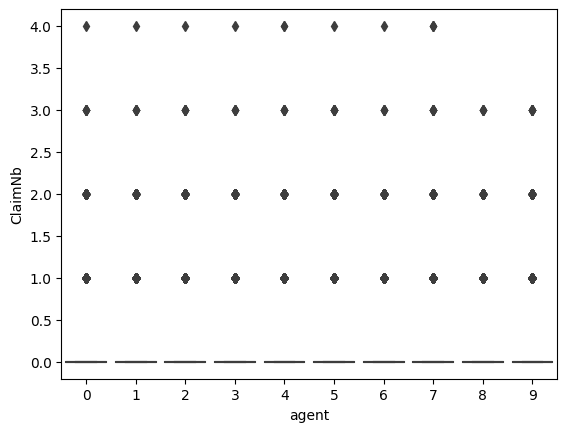

In [50]:
sns.boxplot(data=df_Xy_full, x="agent", y="ClaimNb")

<AxesSubplot: xlabel='agent', ylabel='Area'>

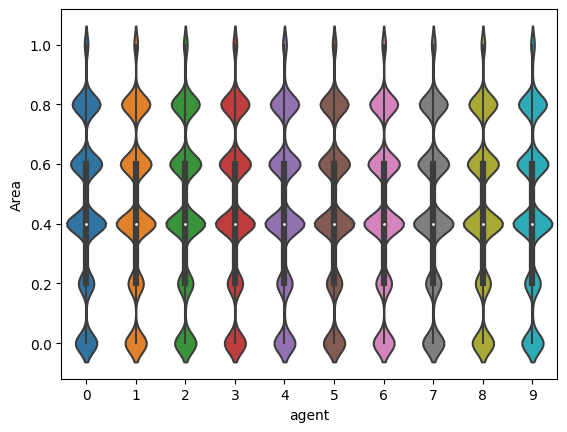

In [51]:
sns.violinplot(data=df_Xy_full, x="agent", y="Area")

<AxesSubplot: xlabel='agent', ylabel='VehPower'>

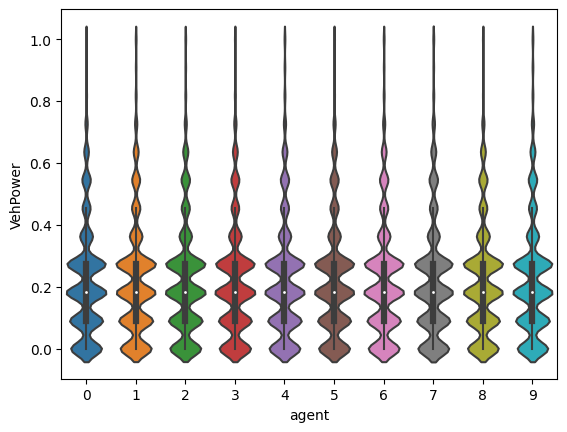

In [52]:
sns.violinplot(data=df_Xy_full, x="agent", y="VehPower")

<AxesSubplot: xlabel='agent', ylabel='VehAge'>

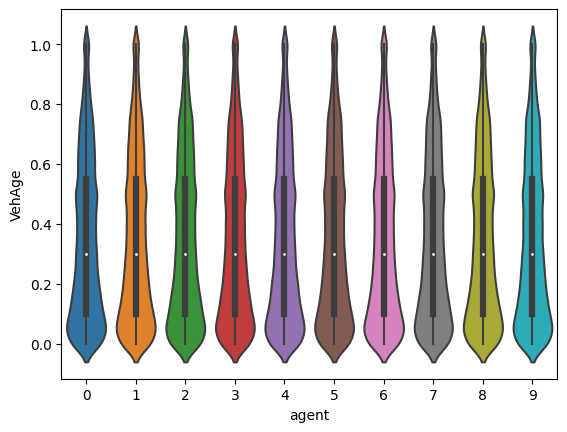

In [53]:
sns.violinplot(data=df_Xy_full, x="agent", y="VehAge")

<AxesSubplot: xlabel='agent', ylabel='DrivAge'>

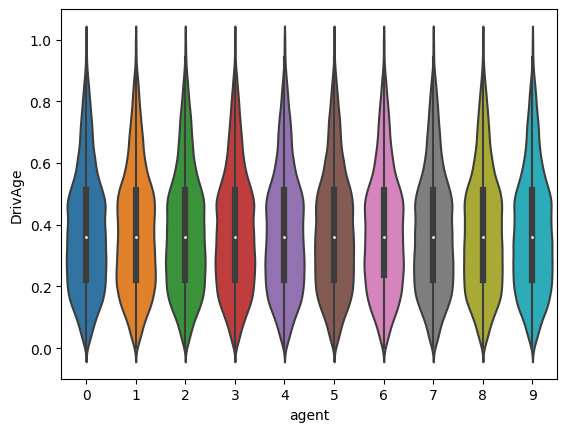

In [54]:
sns.violinplot(data=df_Xy_full, x="agent", y="DrivAge")

<AxesSubplot: xlabel='agent', ylabel='BonusMalus'>

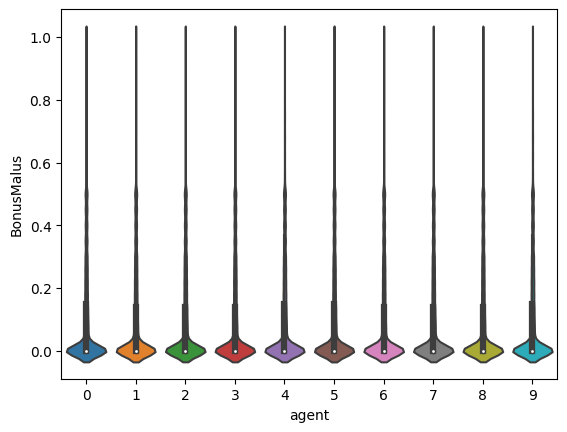

In [55]:
sns.violinplot(data=df_Xy_full, x="agent", y="BonusMalus")

<AxesSubplot: xlabel='agent', ylabel='VehGas'>

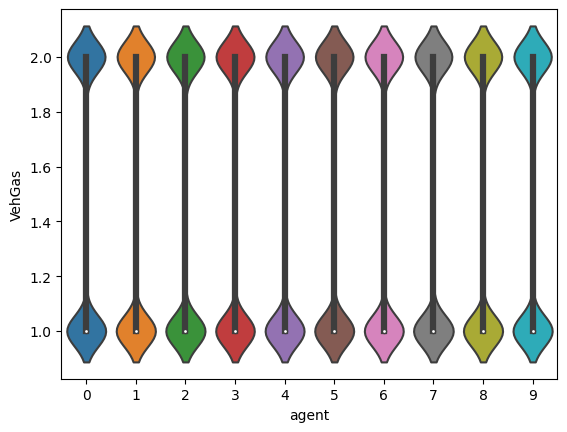

In [56]:
sns.violinplot(data=df_Xy_full, x="agent", y="VehGas")

<AxesSubplot: xlabel='agent', ylabel='Density'>

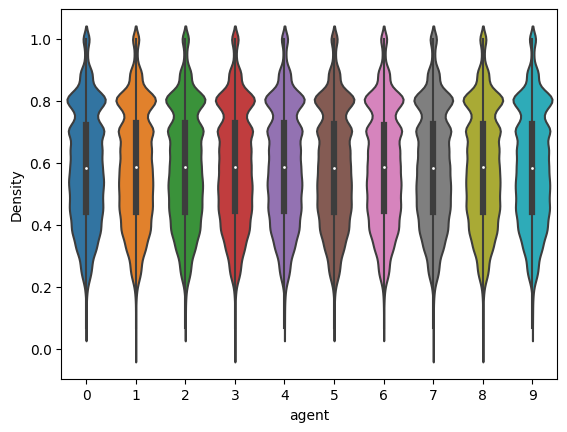

In [57]:
sns.violinplot(data=df_Xy_full, x="agent", y="Density")